## Step 1 — Recreate clustering (if not yet done)

In [35]:
import pandas as pd
import sqlite3

# Load from your database
conn = sqlite3.connect("./../sql/retail_customer_experience.db")

reviews_df = pd.read_sql_query("SELECT customer_id, review_text, rating, review_date FROM customer_reviews;", conn)
tickets_df = pd.read_sql_query("SELECT customer_id, notes, customer_satisfaction_score, submission_date FROM support_tickets;", conn)
conn.close()

# Standardize column names
reviews_df.rename(columns={'review_text': 'text', 'review_date': 'date'}, inplace=True)
tickets_df.rename(columns={'notes': 'text', 'submission_date': 'date'}, inplace=True)

# Combine reviews + tickets into one corpus
feedback_df = pd.concat([
    reviews_df.assign(source='review'),
    tickets_df.assign(source='ticket')
], ignore_index=True)


## Step 2 – Clean the Text

In [36]:
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

feedback_df['clean_text'] = feedback_df['text'].apply(clean_text)


## Step 3 – Sentiment Analysis (using VADER)

In [37]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

analyzer = SentimentIntensityAnalyzer()

feedback_df['sentiment_score'] = feedback_df['clean_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
feedback_df['sentiment_label'] = feedback_df['sentiment_score'].apply(
    lambda x: 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral')
)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Step 4 – Topic Modeling (LDA Example)

In [38]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = CountVectorizer(max_df=0.9, min_df=10, stop_words='english')
X = vectorizer.fit_transform(feedback_df['clean_text'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

topic_words = vectorizer.get_feature_names_out()
for i, topic in enumerate(lda.components_):
    print(f"Topic {i}: ", [topic_words[j] for j in topic.argsort()[-10:][::-1]])


Topic 0:  ['customer', 'unable', 'account', 'information', 'kitchen', 'smart', 'home', 'update', 'delivered', 'package']
Topic 1:  ['customer', 'website', 'requesting', 'account', 'reporting', 'coffee', 'issues', 'maker', 'sony', 'tv']
Topic 2:  ['overall', 'quality', 'life', 'performance', 'ive', 'design', 'battery', 'experience', 'setup', 'impressive']
Topic 3:  ['customer', 'requesting', 'return', 'code', 'wants', 'shipment', 'experiencing', 'inquiring', 'switch', 'cookware']
Topic 4:  ['room', 'design', 'checkout', 'living', 'process', 'decor', 'quality', 'home', 'overall', 'purchased']


In [39]:
topic_results = lda.transform(X)
feedback_df['dominant_topic'] = topic_results.argmax(axis=1)


## Step 5 – Merge Back Into Customer 360

In [40]:
# Average sentiment per customer
sentiment_summary = feedback_df.groupby('customer_id')['sentiment_score'].mean().reset_index()

conn = sqlite3.connect("./../sql/retail_customer_experience.db")
sentiment_summary.to_sql("customer_sentiment", conn, if_exists="replace", index=False)
conn.close()


## Step 6 – Visualize

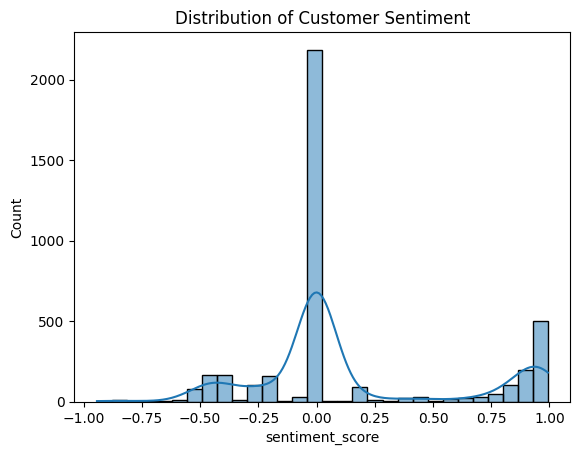

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(feedback_df['sentiment_score'], bins=30, kde=True)
plt.title("Distribution of Customer Sentiment")
plt.show()


#### Word Cloud (for positive & negative)

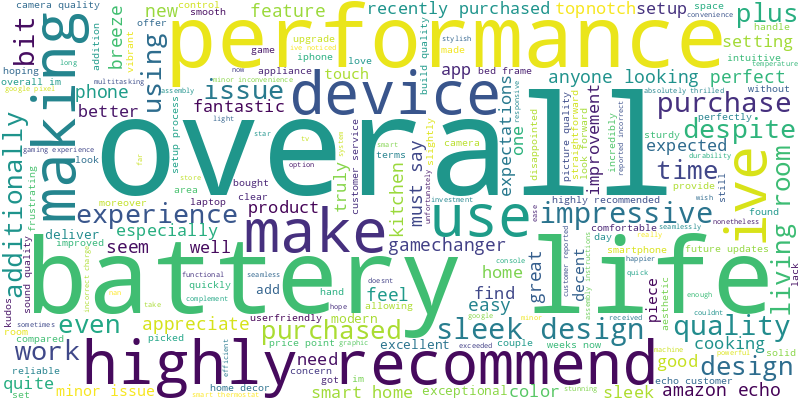

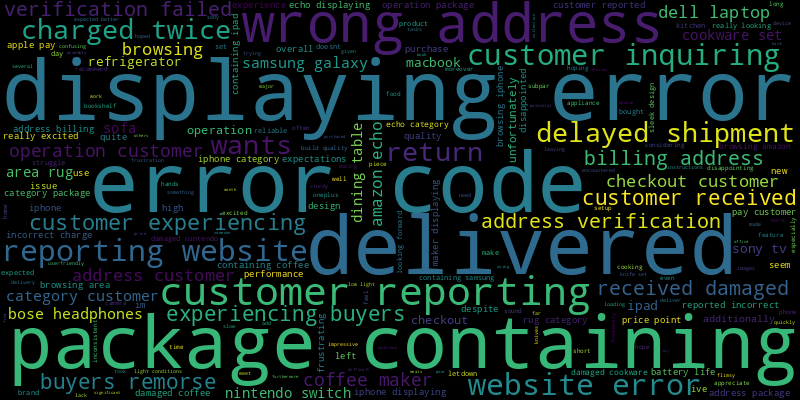

In [42]:
from wordcloud import WordCloud

pos_text = " ".join(feedback_df[feedback_df['sentiment_label']=='positive']['clean_text'])
neg_text = " ".join(feedback_df[feedback_df['sentiment_label']=='negative']['clean_text'])

WordCloud(width=800, height=400, background_color='white').generate(pos_text).to_image().show()
WordCloud(width=800, height=400, background_color='black').generate(neg_text).to_image().show()


#### Topic Frequency

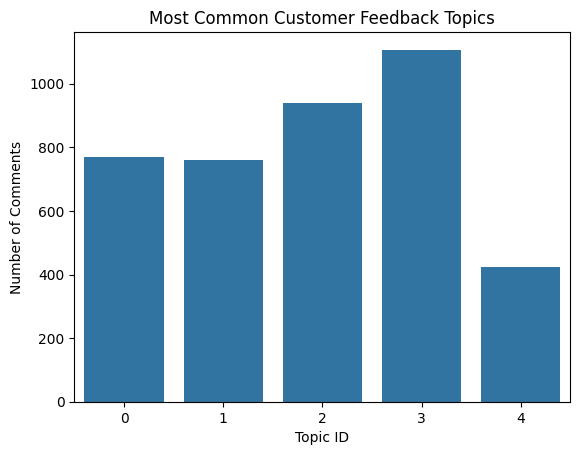

In [43]:
topic_counts = feedback_df['dominant_topic'].value_counts().sort_index()
sns.barplot(x=topic_counts.index, y=topic_counts.values)
plt.title("Most Common Customer Feedback Topics")
plt.xlabel("Topic ID")
plt.ylabel("Number of Comments")
plt.show()


## Goal

#### Merge  customer_sentiment table (from Phase 6) into  master Customer 360 dataset, so each customer has an average sentiment score and label.

## Step 1 — Load Data

In [44]:
import pandas as pd
import sqlite3

# Connect to your database
conn = sqlite3.connect("./../sql/retail_customer_experience.db")

# Load both tables
customer_df = pd.read_sql_query("SELECT * FROM customer_360_cleaned;", conn)
sentiment_df = pd.read_sql_query("SELECT * FROM customer_sentiment;", conn)

conn.close()

print(customer_df.shape, sentiment_df.shape)


(5000, 23) (2682, 2)


## Step 2 — Merge by customer_id

In [45]:
# Merge sentiment data into main customer dataset
customer_enriched = customer_df.merge(sentiment_df, on='customer_id', how='left')

# Fill missing sentiment scores with 0 (no text data = neutral)
customer_enriched['sentiment_score'] = customer_enriched['sentiment_score'].fillna(0)


## Step 3 — Optional: Derive a sentiment label

In [46]:
customer_enriched['sentiment_label'] = customer_enriched['sentiment_score'].apply(
    lambda x: 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral')
)


## Step 4 — Verify the merge

In [47]:
customer_enriched[['customer_id', 'sentiment_score', 'sentiment_label']].head(10)
customer_enriched['sentiment_label'].value_counts()


sentiment_label
neutral     3557
positive     876
negative     567
Name: count, dtype: int64

In [53]:
customer_enriched.head(1)

,customer_id,full_name,city,gender,age,preferred_channel,frequency,monetary,avg_transaction_value,last_purchase_date,...,last_review_date,has_support_history,has_review,has_transaction,recency_days,engagement_score,satisfaction_index,clv_estimate,sentiment_score,sentiment_label
0,4c30e132-0704-4459-a509-9eddde934977,Mark Johnson,Houston,Male,40.0,Unknown,3,3565.72,1188.573333,2024-12-17 00:00:00,...,None,1,0,1,70.0,0.7,3.0,2991.925977,0.0,neutral


## Step 5 — Save Back to the Database

In [48]:
conn = sqlite3.connect("./../sql/retail_customer_experience.db")
customer_enriched.to_sql("customer_360_enriched", conn, if_exists="replace", index=False)
conn.close()

print("✅ Enriched Customer 360 table saved as 'customer_360_enriched'.")


✅ Enriched Customer 360 table saved as 'customer_360_enriched'.


In [49]:
customer_enriched.groupby('city')['sentiment_score'].mean().sort_values(ascending=False).head(10)


city
Vancouver    0.191170
Akron        0.183052
Tempe        0.178743
Mesa         0.148907
Raleigh      0.142155
Detroit      0.129465
Paterson     0.127462
Buffalo      0.119641
Bellevue     0.116672
Allentown    0.116419
Name: sentiment_score, dtype: float64

In [50]:
customer_enriched[['sentiment_score', 'avg_support_score']].corr()


,sentiment_score,avg_support_score
sentiment_score,1.000000,-0.209707
avg_support_score,-0.209707,1.000000


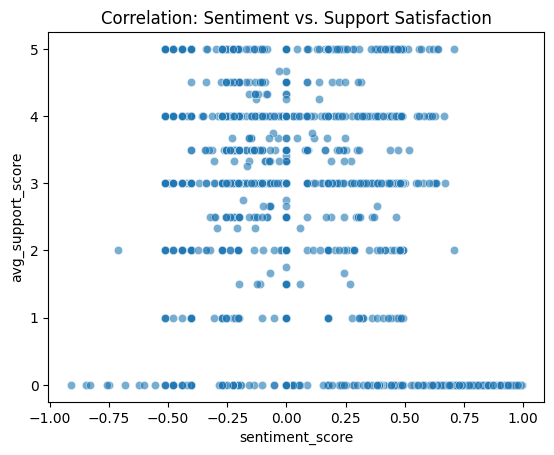

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(
    data=customer_enriched,
    x='sentiment_score',
    y='avg_support_score',
    alpha=0.6
)
plt.title("Correlation: Sentiment vs. Support Satisfaction")
plt.show()


In [52]:
feedback_df

,customer_id,text,rating,date,source,customer_satisfaction_score,clean_text,sentiment_score,sentiment_label,dominant_topic
0,e9848049-323f-4f95-a26e-3cffc219d591,Just received the bookshelf I've been eyeing f...,5.0,2024-06-12,review,NaN,just received the bookshelf ive been eyeing fo...,0.9184,positive,4
1,24bcc3c6-ce17-423f-87f5-a1f6d1114ba7,"Katie Burton, a tech enthusiast from Dallas, T...",5.0,2024-04-05,review,NaN,katie burton a tech enthusiast from dallas tx ...,0.9682,positive,2
2,8806399f-1c9b-47f7-b8ca-fac5468438ff,The OnePlus 10 has been a great addition to my...,4.0,2024-06-29,review,NaN,the oneplus has been a great addition to my te...,0.8625,positive,2
3,62ab496d-f69a-48af-b44c-08ac79b6f68d,The iPhone 13 has been a great addition to my ...,4.0,2024-04-06,review,NaN,the iphone has been a great addition to my tec...,0.8934,positive,2
4,1b7daed4-aaa6-41b1-9826-0d51d67614e3,I recently purchased this bookshelf for my hom...,4.0,2023-09-01,review,NaN,i recently purchased this bookshelf for my hom...,0.9144,positive,4
...,...,...,...,...,...,...,...,...,...,...
3995,780361db-342f-4df7-88fb-45b8535a24d1,Customer received damaged Cookware Set and wan...,NaN,2024-07-19 00:00:00,ticket,3.0,customer received damaged cookware set and wan...,-0.4404,negative,3
3996,fbf1c9b1-b075-4030-a248-931c987946cf,Customer experiencing software issues with Nin...,NaN,2021-05-26 00:00:00,ticket,2.0,customer experiencing software issues with nin...,0.0000,neutral,3
3997,4df0fef7-baf6-4d8e-808c-0abaee321224,Customer experiencing buyer's remorse for Refr...,NaN,2024-03-09 00:00:00,ticket,2.0,customer experiencing buyers remorse for refri...,-0.2732,negative,3
3998,863c69c4-245b-4497-a4a6-62ec3724e31e,Customer received damaged Bose Headphones and ...,NaN,2023-08-16 00:00:00,ticket,2.0,customer received damaged bose headphones and ...,-0.4404,negative,3
